# **III. Entrainement des Models**

## **1. Importation des bibliothèques et du jeu de données (préparé préalablement)**

In [47]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.classification import LinearSVC
from sklearn.metrics import classification_report
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable


In [63]:
# Initialisation de la session Spark // Port : 4040
# Une fois la seesion crée, on peut interagir avec les données stockées dans un environnement distribué.
spark = SparkSession.builder.appName('HeartDiseasesPredicion').config("spark.ui.port", "4041").config("spark.driver.maxResultSize", "4g").getOrCreate()

In [4]:
# Importing data
path = 'clean_data.csv'
data = spark.read.csv(path, header=True, inferSchema=True)

In [5]:
# Assembler les caractéristiques en un vecteur
feature_columns = ['age', 'education', 'sex', 'is_smoking', 'cigs_per_day', 'bp_meds', 'prevalent_stroke', 'prevalent_hyp', 'diabetes', 'total_cholesterol', 'bmi', 'heart_rate', 'glucose', 'pulse_pressure']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

In [6]:
# Diviser les données en ensembles de formation et de test
(trainingData, testData) = data.randomSplit([0.7, 0.3], seed=42)


In [7]:
# Évaluer les modèles sur les données de test
evaluator = BinaryClassificationEvaluator(labelCol="ten_year_chd")


In [48]:
# Créer un évaluateur pour le recall
evaluator_recall = MulticlassClassificationEvaluator(labelCol="ten_year_chd", predictionCol="prediction", metricName="weightedRecall")


## **2. Logistic Regression**

In [8]:
# Entraîner plusieurs modèles de classification
log_reg = LogisticRegression(labelCol="ten_year_chd", featuresCol="features")

In [9]:
# Paramètres à tester pour chaque modèle
param_grid_log_reg = ParamGridBuilder() \
    .addGrid(log_reg.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(log_reg.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

In [10]:
# Instancier les validateurs pour chaque modèle
cv_log_reg = CrossValidator(estimator=log_reg,
                            estimatorParamMaps=param_grid_log_reg,
                            evaluator=evaluator,
                            numFolds=5)

In [11]:
# Entraîner les validateurs
cv_log_reg_model = cv_log_reg.fit(trainingData)

In [12]:
# Sélectionner les meilleurs modèles
best_log_reg_model = cv_log_reg_model.bestModel

In [13]:
# Évaluer les meilleurs modèles
log_reg_test_results = evaluator.evaluate(best_log_reg_model.transform(testData))
print("Logistic Regression Test Area Under ROC:", log_reg_test_results)

Logistic Regression Test Area Under ROC: 0.7206509539842876


In [14]:
# Afficher les meilleurs paramètres pour Logistic Regression
best_log_reg_params = cv_log_reg_model.bestModel.extractParamMap()
print("Meilleurs paramètres pour Logistic Regression:")
for param in best_log_reg_params:
    print(param.name, ":", best_log_reg_params[param])

Meilleurs paramètres pour Logistic Regression:
aggregationDepth : 2
elasticNetParam : 0.0
family : auto
featuresCol : features
fitIntercept : True
labelCol : ten_year_chd
maxBlockSizeInMB : 0.0
maxIter : 100
predictionCol : prediction
probabilityCol : probability
rawPredictionCol : rawPrediction
regParam : 0.1
standardization : True
threshold : 0.5
tol : 1e-06


In [15]:
log_reg_predictions_pd = best_log_reg_model.transform(testData).select("prediction", "ten_year_chd").toPandas()
log_reg_metrics = classification_report(log_reg_predictions_pd["ten_year_chd"], log_reg_predictions_pd["prediction"], zero_division=0)
# Afficher les rapports de classification
print("Logistic Regression Classification Report:")
print(log_reg_metrics)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       810
           1       0.67      0.03      0.05       154

    accuracy                           0.84       964
   macro avg       0.76      0.51      0.48       964
weighted avg       0.82      0.84      0.78       964



In [49]:
# Calculer le recall pour l'ensemble de test
log_reg_test_recall = evaluator_recall.evaluate(best_log_reg_model.transform(testData))

# Calculer le recall pour l'ensemble d'entraînement
log_reg_train_recall = evaluator_recall.evaluate(best_log_reg_model.transform(trainingData))

print("Logistic Regression Test Recall:", log_reg_test_recall)
print("Logistic Regression Train Recall:", log_reg_train_recall)

Logistic Regression Test Recall: 0.8423236514522822
Logistic Regression Train Recall: 0.8573784006595219


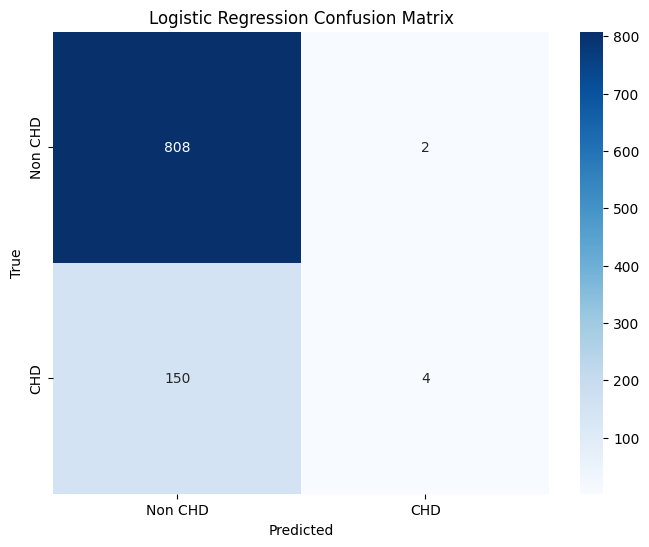

In [16]:
# Définition d'une fonction pour afficher la matrice de confusion
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non CHD', 'CHD'], yticklabels=['Non CHD', 'CHD'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()
# Convertir les prédictions de Spark DataFrame en Pandas DataFrame
log_reg_cm = best_log_reg_model.transform(testData).select("prediction", "ten_year_chd").toPandas()
# Calculer la matrice de confusion pour chaque modèle
log_reg_cm = confusion_matrix(log_reg_cm["ten_year_chd"], log_reg_cm["prediction"])
# Afficher les matrices de confusion
plot_confusion_matrix(log_reg_cm, 'Logistic Regression Confusion Matrix')

## **3. Decision Tree** 

In [17]:
dt = DecisionTreeClassifier(labelCol="ten_year_chd", featuresCol="features")

In [18]:
param_grid_dt = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [16, 32, 64]) \
    .build()

In [19]:
cv_dt = CrossValidator(estimator=dt,
                       estimatorParamMaps=param_grid_dt,
                       evaluator=evaluator,
                       numFolds=5)

In [20]:
cv_dt_model = cv_dt.fit(trainingData)

In [21]:
best_dt_model = cv_dt_model.bestModel

In [22]:
dt_test_results = evaluator.evaluate(best_dt_model.transform(testData))
print("Decision Tree Test Area Under ROC:", dt_test_results)

Decision Tree Test Area Under ROC: 0.5543249959916626


In [23]:
# Afficher les meilleurs paramètres pour Decision Tree
best_dt_params = cv_dt_model.bestModel.extractParamMap()
print("Meilleurs paramètres pour Decision Tree:")
for param in best_dt_params:
    print(param.name, ":", best_dt_params[param])

Meilleurs paramètres pour Decision Tree:
cacheNodeIds : False
checkpointInterval : 10
featuresCol : features
impurity : gini
labelCol : ten_year_chd
leafCol : 
maxBins : 32
maxDepth : 15
maxMemoryInMB : 256
minInfoGain : 0.0
minInstancesPerNode : 1
minWeightFractionPerNode : 0.0
predictionCol : prediction
probabilityCol : probability
rawPredictionCol : rawPrediction
seed : 2339966914054534304


In [24]:
dt_predictions_pd = best_dt_model.transform(testData).select("prediction", "ten_year_chd").toPandas()
dt_metrics = classification_report(dt_predictions_pd["ten_year_chd"], dt_predictions_pd["prediction"], zero_division=0)
print("Decision Tree Classification Report:")
print(dt_metrics)

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       810
           1       0.25      0.29      0.27       154

    accuracy                           0.75       964
   macro avg       0.56      0.56      0.56       964
weighted avg       0.76      0.75      0.76       964



In [50]:
# Calculer le recall pour l'ensemble de test
dt_test_recall = evaluator_recall.evaluate(best_dt_model.transform(testData))

# Calculer le recall pour l'ensemble d'entraînement
dt_train_recall = evaluator_recall.evaluate(best_dt_model.transform(trainingData))

print("Logistic Regression Test Recall:", dt_test_recall)
print("Logistic Regression Train Recall:", dt_train_recall)

Logistic Regression Test Recall: 0.7489626556016598
Logistic Regression Train Recall: 0.9946413849958781


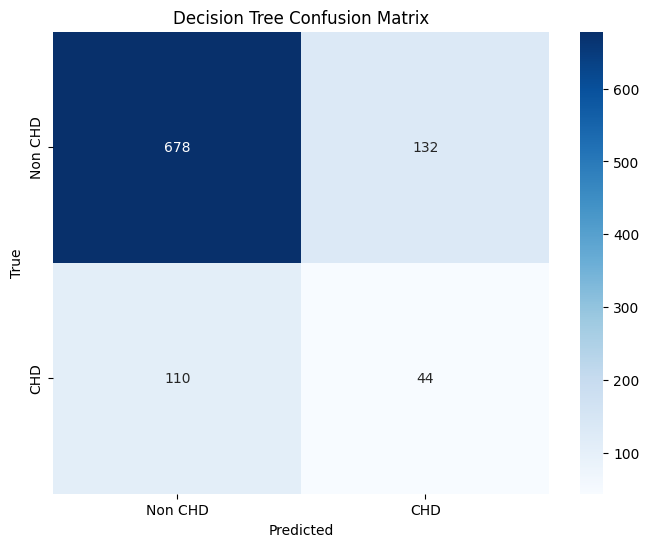

In [25]:
dt_cm = best_dt_model.transform(testData).select("prediction", "ten_year_chd").toPandas()
dt_cm = confusion_matrix(dt_cm["ten_year_chd"], dt_cm["prediction"])
plot_confusion_matrix(dt_cm, 'Decision Tree Confusion Matrix')

## **4. Random Forest**

In [26]:
rf = RandomForestClassifier(labelCol="ten_year_chd", featuresCol="features")

In [27]:
param_grid_rf = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.numTrees, [20, 50, 100]) \
    .build()

In [28]:
cv_rf = CrossValidator(estimator=rf,
                       estimatorParamMaps=param_grid_rf,
                       evaluator=evaluator,
                       numFolds=5)

In [29]:
cv_rf_model = cv_rf.fit(trainingData)

In [30]:
best_rf_model = cv_rf_model.bestModel

In [31]:
rf_test_results = evaluator.evaluate(best_rf_model.transform(testData))
print("Random Forest Test Area Under ROC:", rf_test_results)

Random Forest Test Area Under ROC: 0.6943402276735594


In [32]:
# Afficher les meilleurs paramètres pour Random Forest
best_rf_params = cv_rf_model.bestModel.extractParamMap()
print("Meilleurs paramètres pour Random Forest:")
for param in best_rf_params:
    print(param.name, ":", best_rf_params[param])

Meilleurs paramètres pour Random Forest:
bootstrap : True
cacheNodeIds : False
checkpointInterval : 10
featureSubsetStrategy : auto
featuresCol : features
impurity : gini
labelCol : ten_year_chd
leafCol : 
maxBins : 32
maxDepth : 5
maxMemoryInMB : 256
minInfoGain : 0.0
minInstancesPerNode : 1
minWeightFractionPerNode : 0.0
numTrees : 100
predictionCol : prediction
probabilityCol : probability
rawPredictionCol : rawPrediction
seed : 379411574083385575
subsamplingRate : 1.0


In [33]:
rf_predictions_pd = best_rf_model.transform(testData).select("prediction", "ten_year_chd").toPandas()
rf_metrics = classification_report(rf_predictions_pd["ten_year_chd"], rf_predictions_pd["prediction"], zero_division=0)
print("Random Forest Classification Report:")
print(rf_metrics)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       810
           1       0.45      0.03      0.06       154

    accuracy                           0.84       964
   macro avg       0.65      0.51      0.49       964
weighted avg       0.78      0.84      0.78       964



In [51]:
# Calculer le recall pour l'ensemble de test
rf_test_recall = evaluator_recall.evaluate(best_rf_model.transform(testData))

# Calculer le recall pour l'ensemble d'entraînement
rf_train_recall = evaluator_recall.evaluate(best_rf_model.transform(trainingData))

print("Logistic Regression Test Recall:",rf_test_recall)
print("Logistic Regression Train Recall:", rf_train_recall)

Logistic Regression Test Recall: 0.8392116182572614
Logistic Regression Train Recall: 0.8619126133553174


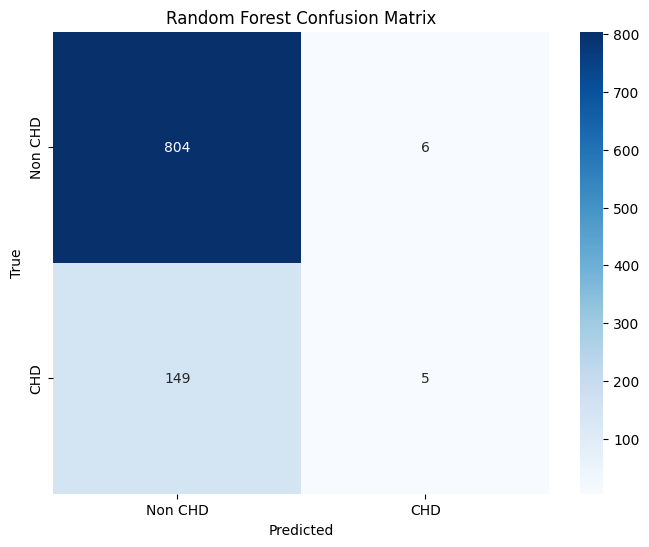

In [34]:
rf_cm = best_rf_model.transform(testData).select("prediction", "ten_year_chd").toPandas()
rf_cm = confusion_matrix(rf_cm["ten_year_chd"], rf_cm["prediction"])
plot_confusion_matrix(rf_cm, 'Random Forest Confusion Matrix')

## **5. Support Vector Machine**

In [35]:
svm = LinearSVC(labelCol="ten_year_chd", featuresCol="features")

In [36]:
# Construire une grille de recherche de paramètres pour chaque modèle
paramGridSVM = ParamGridBuilder() \
    .addGrid(svm.maxIter, [10, 20, 30]) \
    .addGrid(svm.regParam, [0.1, 0.01]) \
    .build()

In [37]:
# Initialiser les validateurs pour SVM
cvSVM = CrossValidator(estimator=svm,
                       estimatorParamMaps=paramGridSVM,
                       evaluator=evaluator,
                       numFolds=5)

In [38]:
# Entraîner les validateurs
cvSVM_model = cvSVM.fit(trainingData)


In [39]:
# Sélectionner les meilleurs modèles
best_svm_model = cvSVM_model.bestModel

In [40]:
svm_test_results = evaluator.evaluate(best_svm_model.transform(testData))
print("Support Vector Machine Test Area Under ROC:", svm_test_results)

Support Vector Machine Test Area Under ROC: 0.6527016193682874


In [41]:
# Afficher les meilleurs paramètres pour SVM.
print("Meilleurs paramètres pour SVM:")
print("MaxIter:", best_svm_model.getMaxIter())
print("RegParam:", best_svm_model.getRegParam())

Meilleurs paramètres pour SVM:
MaxIter: 10
RegParam: 0.01


In [42]:
# Convertir les prédictions de Spark DataFrame en Pandas DataFrame
svm_predictions_pd = best_svm_model.transform(testData).select("prediction", "ten_year_chd").toPandas()
# Utiliser classification_report de scikit-learn sur les données Pandas avec zero_division=0
svm_metrics = classification_report(svm_predictions_pd["ten_year_chd"], svm_predictions_pd["prediction"], zero_division=0)
print("support vector machine Classification Report:")
print(svm_metrics)

support vector machine Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       810
           1       0.00      0.00      0.00       154

    accuracy                           0.84       964
   macro avg       0.42      0.50      0.46       964
weighted avg       0.71      0.84      0.77       964



In [52]:
# Calculer le recall pour l'ensemble de test
svm_test_recall = evaluator_recall.evaluate(best_svm_model.transform(testData))

# Calculer le recall pour l'ensemble d'entraînement
svm_train_recall = evaluator_recall.evaluate(best_svm_model.transform(trainingData))

print("Logistic Regression Test Recall:", svm_test_recall)
print("Logistic Regression Train Recall:", svm_train_recall)

Logistic Regression Test Recall: 0.8402489626556017
Logistic Regression Train Recall: 0.8528441879637263


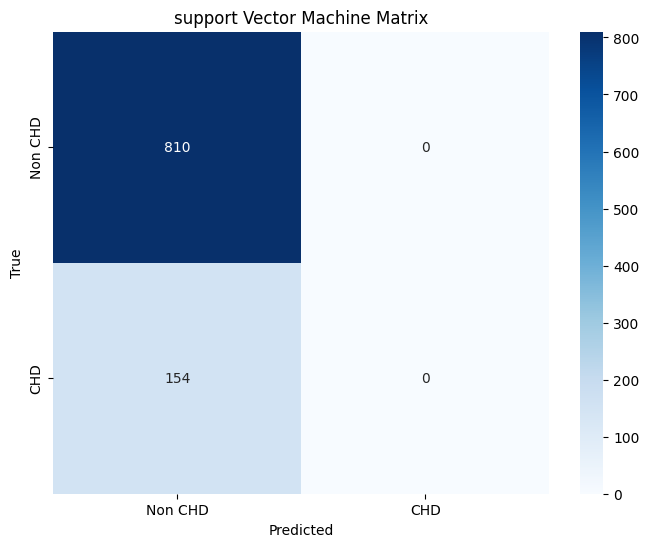

In [43]:
svm_cm = best_svm_model.transform(testData).select("prediction", "ten_year_chd").toPandas()
svm_cm = confusion_matrix(svm_cm["ten_year_chd"], svm_cm["prediction"])
plot_confusion_matrix(svm_cm, 'support Vector Machine Matrix')

## **6. Resultats**

In [53]:
# Summarizing the results obtained
test = PrettyTable(['Sl. No.','Classification Model', 'Train Recall (%)','Test Recall (%)'])
test.add_row(['1','Logistic Regression',log_reg_train_recall*100,log_reg_test_recall*100])
test.add_row(['2','Decision Tree',dt_train_recall*100,dt_test_recall*100])
test.add_row(['3','Support Vector Machines',svm_train_recall*100,svm_test_recall*100])
test.add_row(['4','Random Forests',rf_train_recall*100,rf_test_recall*100])
print(test)

+---------+-------------------------+-------------------+-------------------+
| Sl. No. |   Classification Model  |  Train Recall (%) |  Test Recall (%)  |
+---------+-------------------------+-------------------+-------------------+
|    1    |   Logistic Regression   | 85.73784006595218 | 84.23236514522821 |
|    2    |      Decision Tree      |  99.4641384995878 | 74.89626556016597 |
|    3    | Support Vector Machines | 85.28441879637263 | 84.02489626556017 |
|    4    |      Random Forests     | 86.19126133553175 | 83.92116182572614 |
+---------+-------------------------+-------------------+-------------------+


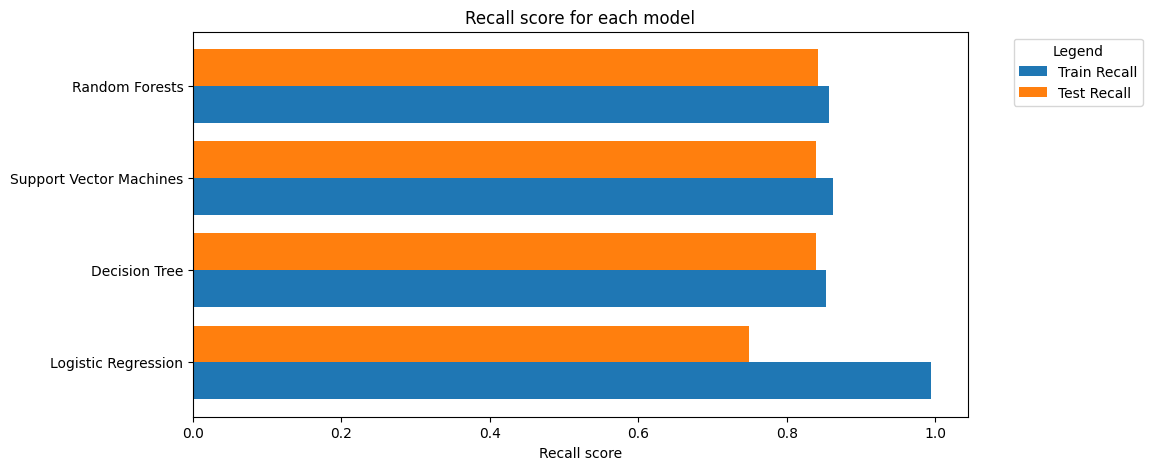

In [54]:
# Plotting Recall scores

ML_models = ['Logistic Regression','Decision Tree','Support Vector Machines','Random Forests']
train_recalls = [dt_train_recall,svm_train_recall,rf_train_recall,log_reg_train_recall]
test_recalls = [dt_test_recall,svm_test_recall,rf_test_recall,log_reg_test_recall]
  
X_axis = np.arange(len(ML_models))

plt.figure(figsize=(10,5))
plt.barh(X_axis - 0.2, train_recalls, 0.4, label = 'Train Recall')
plt.barh(X_axis + 0.2, test_recalls, 0.4, label = 'Test Recall')
  
plt.yticks(X_axis,ML_models)
plt.xlabel("Recall score")
plt.title("Recall score for each model")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',title='Legend')
plt.show()

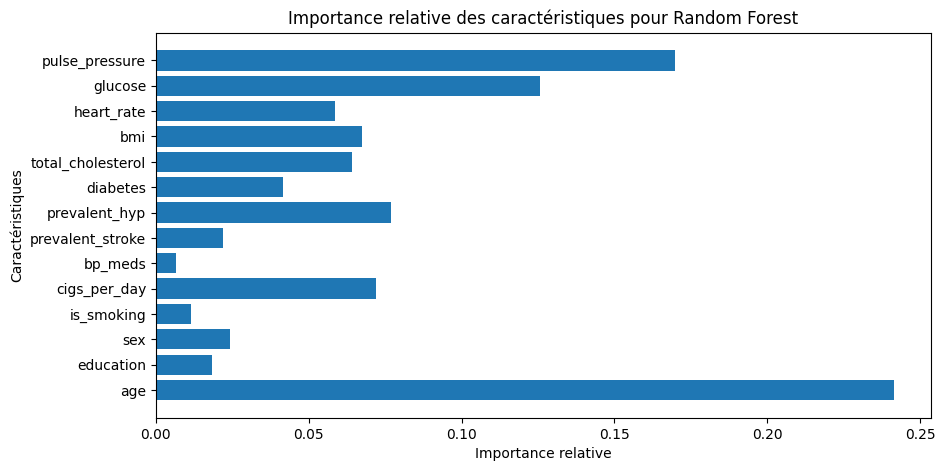

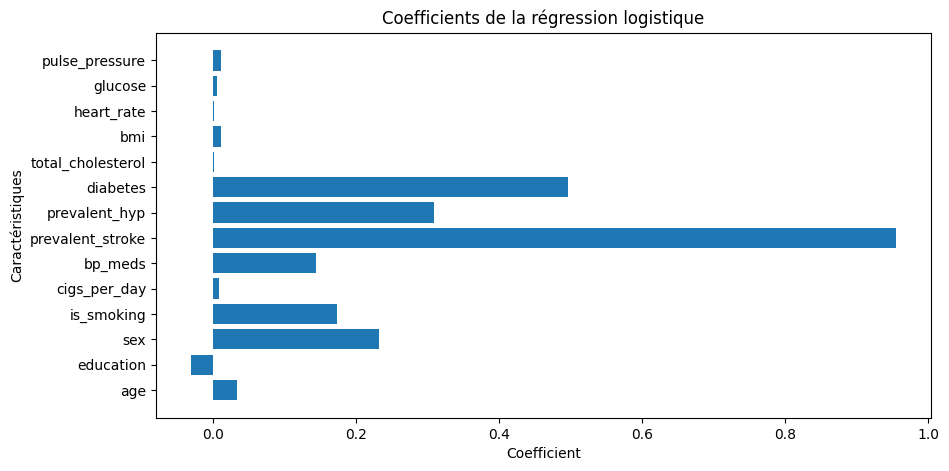

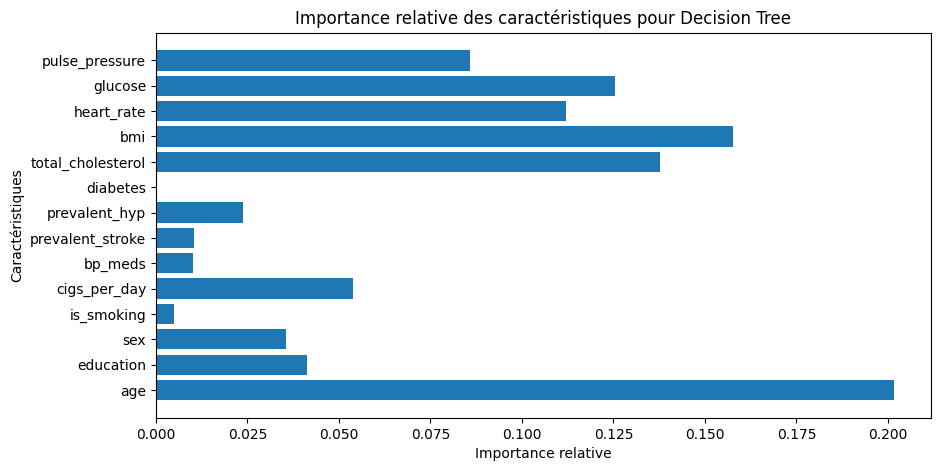

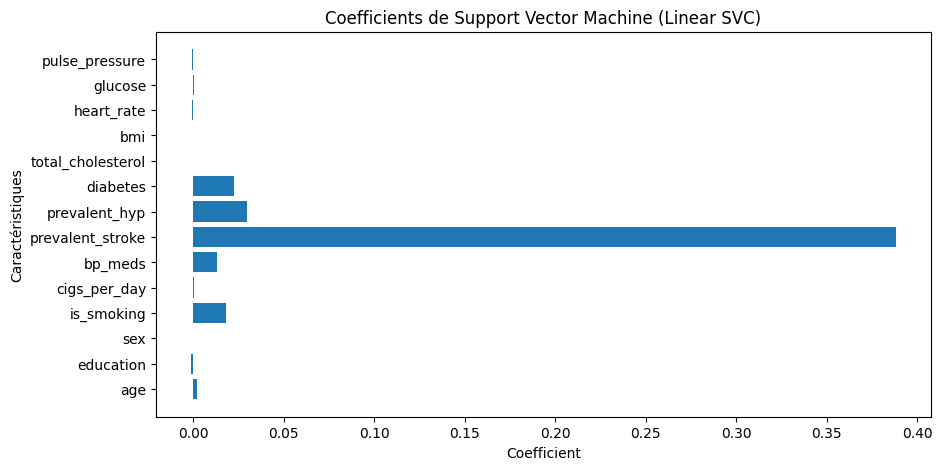

In [15]:
import matplotlib.pyplot as plt

# Random Forest
rf_feature_importance = best_rf_model.featureImportances
plt.figure(figsize=(10, 5))
plt.barh(feature_columns, rf_feature_importance.toArray())
plt.xlabel('Importance relative')
plt.ylabel('Caractéristiques')
plt.title('Importance relative des caractéristiques pour Random Forest')
plt.show()

# Logistic Regression Coefficients
log_reg_coefficients = best_log_reg_model.coefficients

# Créer un graphique des coefficients de régression logistique
plt.figure(figsize=(10, 5))
plt.barh(feature_columns, log_reg_coefficients)
plt.xlabel('Coefficient')
plt.ylabel('Caractéristiques')
plt.title('Coefficients de la régression logistique')
plt.show()


# Decision Tree
dt_feature_importance = best_dt_model.featureImportances
plt.figure(figsize=(10, 5))
plt.barh(feature_columns, dt_feature_importance.toArray())
plt.xlabel('Importance relative')
plt.ylabel('Caractéristiques')
plt.title('Importance relative des caractéristiques pour Decision Tree')
plt.show()


# Support Vector Machine (Linear SVC)
svm_coefficients = best_svm_model.coefficients

# Créer un graphique des coefficients pour Linear SVM
plt.figure(figsize=(10, 5))
plt.barh(feature_columns, svm_coefficients)
plt.xlabel('Coefficient')
plt.ylabel('Caractéristiques')
plt.title('Coefficients de Support Vector Machine (Linear SVC)')
plt.show()

In [44]:
# Convertir les prédictions Spark DataFrame en Pandas DataFrame
dt_predictions_pd = best_dt_model.transform(testData).select("prediction", "ten_year_chd").toPandas()

# Enregistrer les prédictions dans des fichiers CSV
dt_predictions_pd.to_csv('decision_tree_predictions.csv', index=False)


## **7. Déploiment Du Meuilleurs Model**

In [1]:
# a faire